<a href="https://colab.research.google.com/github/gachet/000mis-colabs/blob/master/Module1_Root_finding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Module 1: Root-finding methods

*Material for this worksheet can be found in Chapters 2 of the AE2220-I lecture notes*

### Problem statement

A root-finding method is a numerical method or algorithm to find a value of $x\in[a,b]$,such that $f(x) = 0$, 
where $f$ is a continuous real function of 1-variable on the interval $[a,b]$, written 
$$
f:\mathbb{R}\rightarrow\mathbb{R}, f\in C^0([a,b]).
$$

A value of $x$ satisfying $f(x)=0$ is called a *root* of the function $f$.

Except for special cases, it is usually not possible to find analytic expressions for the roots.  For example, consider expressions for the roots of polynomials: linear - trivial, quadratic - simple, cubic/quartic - possible, quintic and above - impossible (see Abel–Ruffini theorem <a href=https://en.wikipedia.org/wiki/Abel%E2%80%93Ruffini_theorem>[1]</a>). 

Thus computational methods for root-finding problems must be iterative in nature:

- Start with an initial approximation of the root $x_0$.
- Construct a sequence of $x_k = \phi(x_{k-1})$ iterates, for a suitable function $\phi(x)$, with the expectation/hope that $\lim_{k\rightarrow \infty} f(x_k) = 0$.

Three important considerations for iterative methods are:

1. Conditions for convergence (i.e. "Is the root eventually found?")
2. Convergence *rate* (i.e. "How many iterations until the root is found?")
3. Stopping criterion (i.e. "When can we stop iterating?")

These will be examined in detail with the help of plots and sample codes in the following sections.

In [0]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
from copy import copy

In root-finding - and whenever we attempt to solve a problem numerically - we should ask two questions:

- Does a solution <b>exist</b>?
- Is that solution <b>unique</b>?

Generally speaking, we are most happy if the answer to both is "yes".  If the answer to the first is "no", our numerical methods should ideally fail - e.g. report an error, as the problem has no answer.  If the answer to the second is "no", then there are multiple solutions, yet all our numerical methods below will return exactly <b>one</b> solution.  Then we should be aware that our numerical method is giving only a partial answer.

The code given below plots the graphs for the following functions:

$f_\text{poly}(x) = x^3 - x + 1$

$f_\text{tan}(x) = \text{tan}(x) - x$

$f_\text{cos}(x) = \text{cos}(x) - 2x$

$f_\text{exp}(x) = \text{e}^x - 2x$

Run the code for each function and try and visualize if the functions above have a unique solution in a particular interval.  Find intervals $[a,b]$ where (i) multiple solutions exist, (ii) no solutions exist.  Note: plotting $\tan(x)$ and $x$ separately and examining where they cross can give more insight than just plotting $\tan(x)-x$.

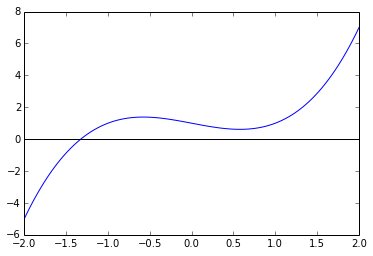

In [0]:
a,b = -2,2

def f_poly(x): return x**3 - x + 1. 
def dfdx_poly(x): return 3.*x**2 - 1.  ### Derivatives are needed later...
def d2fdx2_poly(x): return 6.*x

def f_tan(x): return np.tan(x)-x
def dfdx_tan(x): return np.tan(x)**2 
def d2fdx2_tan(x): return 2.*np.sin(x)/np.cos(x)**3

def f_cos(x): return np.cos(x) - 2.* x 
def dfdx_cos(x): return -np.sin(x) - 2.
def d2fdx2_cos(x): return -np.cos(x)

def f_exp(x): return math.exp(x) - 2.*x
def dfdx_exp(x): return math.exp(x) - 2.
def d2fdx2_exp(x): return math.exp(x)

xx = np.linspace(a,b,101)

plt.plot(xx, f_poly(xx) , '-b')
plt.axhline(y=0,xmin=-2,xmax=2,color='k')  # Plot the y=0 line

#plt.ylim(-2,6) # for f_tan

###  Algorithm #1: Recursive bisection

In the simplest of terms, recursive bisection is a root-finding method that repeatedly bisects an interval and then selects a subinterval in which a root must lie for further processing. It is a very simple and robust method, but also relatively slow. Let us implement the method according to the algorithm from the lecture notes.

In [0]:
def recursive_bisection(ff, a, b, min_error=1.e-8):
    assert ff(a) * ff(b) < 0.                ### check the initial interval contains a root
    ai, bi = float(a), float(b)              ### set initial interval
    plotint = [(ai,bi)]
    while 0.5*np.abs(bi-ai) > min_error:     ### check that we're not converged
        ci = (ai + bi)/2                     ### midpoint of current interval
        if ff(ai) * ff(ci) < 0:              ### select which 1/2 interval to continue with
            bi = ci
        else:
            ai = ci
        plotint.append((ai,bi))              ### store interval for plotting
    return ci, plotint

The following plotting function visualizes the progress of the algorithm:

In [0]:
def bisection_progress_plot(fb, a, b):
    xx = np.linspace(a,b,101)
    plt.figure(figsize=(14,10))
    plt.plot(xx, fb(xx), '-b')               ### plot function
    for i,(ai,bi) in enumerate(plotint):     ### plot intervals/midpoints
        height = -4.*i/len(plotint)
        plt.plot([ai,bi], height*np.array([1.,1.]), '--or')
        plt.plot([(ai+bi)/2,(ai+bi)/2], height*np.array([1.,1.]), '-oy')
        plt.text(ai-(b-a)/40., height, r"$%d$"%i, fontsize=10)
    plt.ylim(-4,4)


In [0]:
xreference, plotint = recursive_bisection(f_poly, a, b, 1.e-6)
print('Approximation:',xreference)
bisection_progress_plot(f_poly, a, b)

The only modification we have made is to check initially if a root exists in the interval (try removing this and see what happens for an interval for which the condition is not satisfied).  Also the intermediate intervals are stored so that we can plot them later and see the progress of the method.

#### Convergence plot - Measures of error

We are interested in methods that <i>converge</i> quickly, i.e. for which the error reduces rapidly as $k$ increases.  We define the **true error** with respect to the exact solution $\tilde x$:
$$
\tilde e_k := x_k - \tilde x.
$$
However $\tilde x$ is unknown - it's the quantity we're trying to find!  We say $e_k$ is not *computable*.  As a compromise we plot the **approximate error** with respect to the solution on the <i>final iteration</i> - using this as a reference solution, under the assumption that it is more accurate than the solution at all other iterations, and therefore estimates of the error will not be too far off:
$$
\tilde e_k \simeq \hat e_k := x_k - x_{k,\text{final}}.
$$
This is not ideal, as $x_{k,\text{final}}$ is only known at the end of the process, and if the process doesn't converge our reference solution is bad, and $\hat e_k$ may be zero even though $f(x_k)=0$ is not satisfied.  Therefore the  **residual error** is useful:
$$
\epsilon_k := f(x_k)
$$
which is easy to compute, and only zero if the equation is satisfied.

Finally a particular algorithm may have an **error estimate**.  In recursive bisection we have a guarantee that the root is in the interval $[a_k, b_k]$, giving us an upper bound on the error of:
$$
\bar e_k := \frac{b_k - a_k}{2}.
$$

In [0]:
def bisection_convergence(plotint,xrefer,f_bis):
    n = len(plotint)-1
    nn = range(n)
    error_estimate, error_approx, error_residual = np.zeros(n), np.zeros(n), np.zeros(n)
    for i in range(n):
        ai, bi = plotint[i][0], plotint[i][1]
        ci = (ai + bi)/2
        error_estimate[i] = (bi - ai)/2
        error_approx[i]     = np.abs(ci - xrefer)
        error_residual[i] = np.abs(f_bis(ci))
    
    plt.plot(nn[:-1], np.log10(error_approx[:-1]), '-o', label=r'$\hat e_k$ - Approximate error')
    plt.plot(nn, np.log10(error_estimate), '-o', label=r'$\bar e$ - RB Error estimate')
    plt.plot(nn, np.log10(error_residual), '-o', label=r'$\epsilon$ - Residual error')
    plt.xlabel(r'$n$', fontsize=20)
    plt.ylabel(r'$\mathrm{log}_{10}(e)$', fontsize=20)
    plt.legend()

In [0]:
bisection_convergence(plotint,xreference,f_poly)

**Exercise 1:**

**(a) For a given min_error $\epsilon$, predict the minimum number of iterations $N$ required.**  Hint: If $c_1 = \frac {a+b}{2}$ is the midpoint of the initial interval and $c_n$ is the midpoint of the interval in the nth step, then the difference between $c_n$ and a solution $c$ is bounded by $|c_n-c| \leq \frac{| b-a |}{2^n}$.

**(b) Consider the function $f(x) =\tan x - x$ in the interval $(-0.5,5).$**

  0. **Plotting the function $y=\tan x$ and $y = x$ earlier has given as an idea of the roots in the interval. Try finding the first non-zero positive root by starting with the interval $(1.0,5.0)$. Does the method converge to the first root? Why not? Is it possible to find the root by changing the interval?**

  0. **Try to find the first root using the same interval.** Hint: Consider rewriting the function such that it is continous in the interval (1.0,5.0) 


In [0]:
### TODO
# You can call the already written functions recursive_bisection and bisection_progress_plot
# directly by using arguments according to the question
a1, b1 = 1.0, 5.0
xx = np.linspace(a,b,101)

**(c) The "true" error is always less than the estimated error - why?**

### Algorithm #2: Fixed-point iteration

Unlike recursive bisection, there are multiple possible Fixed Point Iterations for a given function. Recall that for the original equation  $f(x) = 0$, we need to define a $\varphi(x)$ such that the equation can be rearranged to:
$$
x = \varphi(x)
$$

Then an initial guess $x_0$ generates a sequence of estimates for the fixed point by setting:
$$
 x_{k+1} = \varphi(x_k), \hspace{1cm} k= 1,2,...
$$
We will consider the function $f(x) = \cos x - 2x$

First choose a $\varphi(x)$:

In [0]:
def phi(x): return 0.5*np.cos(x)

The implementation is extremely concise:

In [0]:
def fixed_point(phi, x0, n_max):
    plot_fpi = [x0]                  ### Store intermediate results for plotting
    xi = x0
    for i in range(n_max):
        xi = phi(xi)
        plot_fpi.append(xi)          ### Store intermediate results for plotting
    return xi, np.array(plot_fpi)

Again, visualization helps:

In [0]:
def FPI_progress_plot(phi, a, b, plot_fpi):
    xx = np.linspace(a,b,101)        ### change the values of a and b to zoom in on the 
                                     ### plot to get a clearer view of the behaviour of 
                                     ### the method  
    plt.figure(figsize=(10,8))
    plt.plot(xx, phi(xx), '-k', label=r'$\varphi$')       ### plot function
    plt.plot(xx, xx, '-r', label=r'$x=y$')                ### plot y=x
    for i in range(len(plot_fpi)-1):                      ### plot construction lines 
        plt.plot([plot_fpi[i],plot_fpi[i]], [plot_fpi[i], phi(plot_fpi[i])], '-ob')
        plt.plot([plot_fpi[i],plot_fpi[i+1]], [phi(plot_fpi[i]), phi(plot_fpi[i])], '-ob')
    plt.legend(loc='lower right')

In [0]:
x0 = 1.0
a, b = -2, 2
xreference, plot_fpi = fixed_point(phi, x0, 50)
FPI_progress_plot(phi,a,b,plot_fpi)
xreference

And the convergence plot (we don't have an good error estimate $\bar e_k$, here unlike for RB):

In [0]:
### Ignore the last point in the convegence histories, that's
### the reference!
def FPI_convergence(plot_fpi, xreference, f_FPI):
    n = len(plot_fpi)-1
    nn = range(n)
                                           ### Compute the errors
    plot_fpi_error = np.abs(plot_fpi[:-1] - xreference)
    plot_fpi_residual = np.abs(f_FPI(plot_fpi[:-1]))
                                           ### Plot the errors against n
    plt.figure(figsize=(12,5))
    plt.subplot(121)
    plt.plot(nn, np.log10(plot_fpi_error), '-o', label=r'$\hat e_k$ - Approximate error')
    plt.plot(nn, np.log10(plot_fpi_residual), '-o', label=r'$\epsilon_k$ - Residual error')
    plt.xlabel(r'$k$', fontsize=20)
    plt.ylabel(r'$\mathrm{log}_{10}(e)$', fontsize=20)
    plt.legend()
                                           ### Plot the convergence rate against n
    plt.subplot(122)
    plt.plot(nn[:-1], plot_fpi_residual[1:]/plot_fpi_residual[:-1], '-og')
    plt.xlabel(r'$k$', fontsize=20)
    plt.ylabel(r'$e_{k+1}/e_k$', fontsize=20)

In [0]:
FPI_convergence(plot_fpi, xreference, f_cos)

We've also plotted the <i>convergence rate</i> - i.e. the factor by which the error is reduced from one iteration to the next.  This plot has a plateau corresponding to the straight-line reduction of error in the left-hand plot.  [Convince yourself of this relationship; how would the left-hand plot change if the plateau moved up/down?]

#### Stability of fixed-point iterations

From the notes we know that for FPI to be stable and avoid divergence,
$$
\left|\frac{d\varphi(x)}{dx}\right| < 1 \quad \mbox{for all}\quad x\in [x_0, \tilde x].
$$
We can verify by that the choice of $\varphi(x)$ used above satisfies the condition near the exact root $\tilde x$:

In [0]:
def dphidx(x): return 0.5*(-np.sin(x))

In [0]:
xx = np.linspace(a,b,101)
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(xx, f_cos(xx), '-b', label=r'$f(x)$')       ### plot function
plt.plot(xx, xx*0, '-k', label=r'$y=0$')      ### plot y=0
plt.legend()
plt.subplot(212)
plt.plot(xx, dphidx(xx), '-r', label=r'$|d\varphi(x)/dx|$')  ### plot function
plt.plot(xx, xx*0+1, '-k', label=r'$y=1$')      ### plot y=0
plt.legend()

<b>Exercise 2:</b>

**(a) Are these results consistent with the theory?  In particular, how is the rate of convergence related to $\varphi'(\tilde x)$?  Compute $\varphi'(\tilde x)$ at the root and compare it with the plateau in the convergence-rate plot.  Do they agree?  Why?**

**(b) Consider the function $x=\tan x$. Select an appropriate $\varphi(x)$ and try and plot the values in the interval $(0,4.6)$. Are there any roots of $f(x)$ (outside the interval), to which the FPI will not converge?**

**(c) Consider a different choice of $\varphi(x)$.  How many possible choices are there?  Can you find a $\varphi(x)$ that converges to the roots which the other $\varphi$ didn't converge to?**

In [0]:
### TODO
a,b = 0.0,4.6
xx = np.linspace(a,b,101)

### Algorithm #3: Newton's method

Newton's method is the most popular solution method, because it works for functions of arbitrarily many variables (unlike recursive bisection), and does not require careful choice of $\varphi$ (unlike FPIs).  Newton's method can be expressed as:
$$
x_{k+1} = x_k - \frac{f(x_k)}{f'(x_k)},
$$
so requires the derivative of $f$ as an argument:

In [0]:
def newton(f, dfdx, x0, n_max):
    plot_newton = [x0]                  ### Store intermediate results for plotting
    xi = x0
    for i in range(n_max):
        xi = xi - f(xi)/dfdx(xi)
        plot_newton.append(xi)          ### Store intermediate results for plotting
    return xi, np.array(plot_newton)

In [0]:
def newton_progress_plot(a,b,fn):
    xx = np.linspace(a,b,101)

    plt.figure(figsize=(14,10))
    plt.plot(xx, fn(xx), '-b', label=r'$f(x)$')       ### plot function

    plt.plot(xx, xx*0, '-k', label=r'$y=0$')         ### plot y=0
    for i in range(len(plot_newton)-1):                    ### plot construction lines 
        plt.plot([plot_newton[i],plot_newton[i]], [0,fn(plot_newton[i])], '-or')
        plt.plot([plot_newton[i],plot_newton[i+1]], [fn(plot_newton[i]),0], '-or')
    plt.legend()
    plt.ylim(-2,2)

For the Newton's method, the selection of the initial value is important for convergence. For the polynomial function, notice that $f(-2) = 5$ and $f(-1) = 1$. Hence we can deduce that the root is between -2 and 1. So let us start with an initial value of $x_0 = -1$  

In [0]:
x0 = -1.
a,b = -2,2
xref_newton, plot_newton = newton(f_poly, dfdx_poly, x0, 20)
newton_progress_plot(a,b,f_poly)
xref_newton


Plotting the behaviour of the method has given us some insights (hopefully).A good indication of the general behaviour of the Newton method can be seen from the following link
$\href{https://en.wikipedia.org/wiki/Newton%27s_method#/media/File:NewtonIteration_Ani.gif}{[2]}$

Try the newton method for the f_cos function and  see if the method converges to the root (Plotting the function in Section 1 would be a good idea to see where the root lies so that we can pick an initial value accordingly).

The convergence plot for Newton is qualitatively different from that of Recursive Bisection and Fixed Point Iterations:

In [0]:
def newton_convergence(plot_newton,xref,f):
                                             ### Ignore the last point in the convegence 
                                             ### histories, that's the reference!
    n = len(plot_newton)-1
    nn = range(n)
                                             ### Compute the errors
    plot_newton_error = np.abs(plot_newton[:-1] - xref)
    plot_newton_residual = np.abs(f(plot_newton[:-1]))
                                             ### Plot the errors against n
    plt.figure(figsize=(12,5))
    plt.subplot(121)
    plt.plot(nn, np.log10(plot_newton_error), '-o', label='True error in $x$')
    plt.plot(nn, np.log10(plot_newton_residual), '-o', label='Residual error')
    plt.xlabel(r'$n$', fontsize=20)
    plt.ylabel(r'$\mathrm{log}_{10}(e)$', fontsize=20)
    plt.legend()
                                             ### Plot the convergence rate against n
    plt.subplot(122)
    plt.plot(nn[:-1], plot_newton_residual[1:]/plot_newton_residual[:-1], '-og')
    plt.xlabel(r'$n$', fontsize=20)
    plt.ylabel(r'$e_{n+1}/e_n$', fontsize=20)

In [0]:
newton_convergence(plot_newton,xref_newton,f_poly)

Newton's method is a fixed-point iteration with $\varphi(x)$ choosen as:
$$
\varphi(x) = x - \frac{f(x)}{f'(x)}
$$
and we saw in the notes that
$$
\varphi'(x) = \frac{f(x)f''(x)}{(f'(x))^2},
$$
Plotting:

In [0]:
def dphi_newtondx(x,f,fp,fpp): return f(x)*fpp(x) / (fp(x)**2)

In [0]:
xx = np.linspace(a,b,101)
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(xx, f_poly(xx), '-b', label=r'$f(x)$')    ### plot function
plt.plot(xx, xx*0, '-k', label=r'$y=0$')      ### plot y=0
plt.legend()
plt.subplot(212)
plt.plot(xx, np.abs(dphi_newtondx(xx,f_poly,dfdx_poly,d2fdx2_poly)), '-r', 
             label=r'$|d\varphi(x)/dx|$')  ### plot dphi'
plt.plot(xx, xx*0, '-k', label=r'$y=0$')      ### plot y=0
plt.plot(xx, xx*0+1, '-k', label=r'$y=1$')      ### plot y=1
plt.ylim(-1,3)
plt.legend()

And we see that at the root $\varphi'(\tilde x) =0$ , explaining the amazing performance of Newton's method.

**Exercise 3:**

**(a) We examine the importance of the initial value $x_0$.**

  0. **The function $f(x) =xe^{-x^2}$ has a zero at $x=0$. Use the Newton's method to try and find this root using an initial value $x_0 =1$.**  Hint: Plotting the graph of the function might explain this peculiar behaviour

  0. **What happens and why when the initial value $x_0 = 0.5$ is chosen?**

  0. **Now try to find an initial value that will lead to the solution.**





In [0]:
### TODO

**(b) Convergence.  We shall consider the same function $f(x) =\tan x - x$ in the interval $(-1.0,5).$ and try and find all roots in the interval (zero and positive) using the Newton method. Since we have already checked the sensitivity of the initial value in the previous question, use initial values of $x_0 = -1$ and $x_0 = 4.$ for finding the roots. Is there any difference between the rate of convergence for the two roots? Is this result consistent with the theory learnt in the lectures?** 

In [0]:
### TODO
# Again use the already defined functions for the newton method calculation,plotting and convergence
a, b = -.5, 5.
xx = np.linspace(a,b,101)


### Finally: Multi-dimensional problems

The real power (and necessity) for root-finding methods occurs in the multidimensional case:
$$
f: \mathbb{R}^n \rightarrow \mathbb{R}^n
$$
i.e. $f$ has $n$ inputs and $n$ outputs.  Then the equation
$$
f(\mathbf{x}) = \mathbf{0}
$$
represents a system of $n$ non-linear equations in $n$ unknowns.  In the <i>linear</i> case (where $f(\mathbf{x}) = A\mathbf{x} - \mathbf{b}$), we know exactly when these problems have unique solutions, and we have methods for finding them (Linear Algebra).  In the non-linear case, unless we're lucky, we need to use numerical methods.  

The derivation of Newton's method becomes: the Taylor series of $f$ at $x_k$ iswritten:
$$
f(\mathbf{x}) = f(\mathbf{x}_k) + J(\mathbf{x}_k) (\mathbf{x}-\mathbf{x}_k) + \mathcal{O}(\mathbf{x}-\mathbf{x}_k)^2
$$
where 
$$
J(\mathbf{x}) := \left( \begin{array}{ccc}
             \frac{\partial f_1(x)}{\partial x_1} & \cdots & \frac{\partial f_1(x)}{\partial x_n} \\
             \vdots & \ddots & \vdots \\
             \frac{\partial f_n(x)}{\partial x_1} & \cdots & \frac{\partial f_n(x)}{\partial x_n} \end{array} \right)
$$ 
is the $(n\times n)$ Jacobian matrix.  Neglecting higher-order terms, and setting the intercept to $0$ at the $k+1$th iteration gives:
$$
0 = f(\mathbf{x}_k) + J(\mathbf{x}_k) (\mathbf{x}_{k+1}-\mathbf{x}_k),
$$
leading to an expression for the Newton iteration
$$ 
\mathbf{x}_{k+1} = \mathbf{x}_k - J(\mathbf{x}_k)^{-1} f(\mathbf{x}_k).
$$
Each iteration requires:

  0. Evaluation of $f(\mathbf{x}_k)$.
  0. Evaluation of $J(\mathbf{x}_k)$.
  0. Solution of a linear system of algebraic equations $J(\mathbf{x}_k) \Delta \mathbf{x}_k = -f(\mathbf{x}_k)$ for the update.
  0. Application of the update $\mathbf{x}_{k+1} = \mathbf{x}_k + \Delta \mathbf{x}_k$.

  

In [0]:
def newton_mdimensional(f, dfdx, x0, n_max):
    plot_newtonm = [copy(x0)]
    xi = x0
    for i in range(n_max):
        deltaxi = np.linalg.solve(dfdx(xi), -f(xi))
        xi += deltaxi
        plot_newtonm.append(copy(xi))
    return xi, np.array(plot_newtonm)

#### A sample 2-dimensional problem

Find $x$, $y$ such that:
$$
x^2+y^2=1, \quad xy=\frac{1}{4}
$$

In [0]:
def f(xv): 
    x, y = xv[0], xv[1]
    return np.array([1-x**2-y**2, .25 - x*y])

In [0]:
def dfdx(xv):
    x, y = xv[0], xv[1]
    return np.array([[-2*x,-2*y],
                     [  -y,  -x]])

In [0]:
x0 = np.array([-2.0,1.0])
xreference, plot_newtonm = newton_mdimensional(f, dfdx, x0, 10)
xreference

It's a good idea to check the residual, to see if this is really a solution:

In [0]:
f(xreference)

We can also look at the path the solution took in the $(x,y)$ plane:

In [0]:
xx = np.linspace(-2.,2.,101)
plt.figure(figsize=(8,8))
### Plot lines on which individual equations are satisfied
plt.plot(xx, np.sqrt(1-xx**2), '-k', label='Eqn 1')
plt.plot(xx, -np.sqrt(1-xx**2), '-k')
plt.plot(xx, 1./(4*xx), '-r', label='Eqn 2')
plt.xlim(-2,2); plt.ylim(-2,2)
### Plot path of Newton
n = len(plot_newtonm)
plt.plot(plot_newtonm[:,0], plot_newtonm[:,1], '-ob')
plt.legend()
plot_newtonm[:,1]

How many roots of this equation exist?  From which $x_0$ does Newton converge to which root?  Are there values of $x_0$ for which it doesn't converge at all?